## Part 2 of: "learning the Q-values with a neural network" ##

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
tf.keras.backend.set_floatx('float64')
from misc import *
from collections import deque
from datetime import datetime
import random

In [7]:
def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def qval(beta, n, guess):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    pn = np.sum([Prob(g*alpha, beta, n) for g in [-1,1]])
    return Prob(guess*alpha, beta, n)/pn


In [8]:
def createdataset_l2(number_rews_per_beta_per_outcome_per_guess=10**2,number_of_betas = 10):
    #we call it l2 so it does not interfer with the fist tutoral..
    dataset = []
    labels=[]
    global betas_train
    global number_of_samples
    number_of_samples = number_rews_per_beta_per_outcome_per_guess
    betas_train = np.linspace(-1.5,1.5,number_of_betas)
    for i in range(len(betas_train)):
        beta = betas_train[i]
        for outcome in [0.,1.]:
            for guess in [-1.,1.]:

                for k in range(number_rews_per_beta_per_outcome_per_guess):
                    mean_bernoulli = qval(beta, outcome, guess)
                    reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]

                    dataset.append([beta, outcome, guess, reward])
    return np.array(dataset)

In [19]:

class Net(tf.keras.Model):
    def __init__(self, valreg=0.01, seed_val=0.1):
        super(Net,self).__init__()

        self.l1 = Dense(3, input_shape=(3,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name


In [21]:

global dataset, net
dataset = createdataset_l2(100, number_of_betas=10)

dataset_copy = dataset.copy()
np.random.shuffle(dataset)
batch_size = len(dataset)/10
print("Training with batch_size of: ", batch_size)
dataset = np.split(dataset, 10 + len(dataset)%10) #spliting the dataset!
net = Net()


Training with batch_size of:  400.0


In [47]:
tf.random.set_seed(10)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
net = Net()
batch = dataset[0]
with tf.GradientTape() as tape:
    tape.watch(net.trainable_variables)
    preds = net(batch[:,[0,1,2]]) #make predictions in batch
    rews = batch[:,3]
    loss = tf.keras.losses.MSE(rews,preds)
    loss = tf.reduce_mean(loss)

    grads = tape.gradient(loss, net.trainable_variables)
    optimizer.apply_gradients(zip(grads, net.trainable_variables))
    
    for var in optimizer.variables():
        print(var)


<tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1>
<tf.Variable 'Adam/net_20/dense_100/kernel/m:0' shape=(3, 3) dtype=float64, numpy=
array([[ 1.05699883e-05,  1.67605776e-05,  2.80639326e-05],
       [-1.06030159e-05, -1.37326444e-05, -6.04632846e-05],
       [ 2.88909158e-05, -2.45597834e-05,  1.86991317e-05]])>
<tf.Variable 'Adam/net_20/dense_100/bias/m:0' shape=(3,) dtype=float64, numpy=array([-2.88909158e-05, -2.45597834e-05, -1.18777896e-04])>
<tf.Variable 'Adam/net_20/dense_104/kernel/m:0' shape=(3, 1) dtype=float64, numpy=
array([[6.26533941e-05],
       [5.04860494e-05],
       [2.73609670e-04]])>
<tf.Variable 'Adam/net_20/dense_104/bias/m:0' shape=(1,) dtype=float64, numpy=array([0.00220668])>
<tf.Variable 'Adam/net_20/dense_100/kernel/v:0' shape=(3, 3) dtype=float64, numpy=
array([[1.11723160e-11, 2.80913212e-11, 7.87573800e-11],
       [1.12422445e-11, 1.88583005e-11, 3.65575997e-10],
       [8.34673869e-11, 6.03174906e-11, 3.49652859e-11]])>
<tf.Variable 'Adam/net_2

In [17]:
histo_preds = {} #here i save the predictions

for epoch in tqdm(range(3)):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for batch in tqdm(dataset):
        with tf.GradientTape() as tape:
            tape.watch(net.trainable_variables)
            preds = net(batch[:,[0,1,2]]) #make predictions in batch
            rews = batch[:,3]
            loss = tf.keras.losses.MSE(rews,preds)
            loss = tf.reduce_mean(loss)

            grads = tape.gradient(loss, net.trainable_variables)
            optimizer.apply_gradients(zip(grads, net.trainable_variables))
        epoch_loss_avg(loss)

NameError: name 'epochs' is not defined

In [154]:
def learning_problem(rews_per_beta, epochs=30, number_of_splits=100, number_of_betas=10, lr=10**(-3)):
    start = datetime.now()
    optimizer = tf.keras.optimizers.Adam(lr=lr)

    global dataset, net
    dataset = createdataset_l2(rews_per_beta, number_of_betas=number_of_betas)
    dataset_copy = dataset.copy()
    np.random.shuffle(dataset)
    
    batch_size = len(dataset)/number_splits
    print("Training with batch_size of: ", batch_size)
    dataset = np.split(dataset, number_of_splits + len(dataset)%number_of_splits) #spliting the dataset!
    net = Net()
    
    
    histo_preds = {} #here i save the predictions

    for epoch in tqdm(range(epochs)):
        epoch_loss_avg = tf.keras.metrics.Mean()

        for batch in tqdm(dataset):
            with tf.GradientTape() as tape:
                tape.watch(net.trainable_variables)
                preds = net(batch[:,[0,1,2]]) #make predictions in batch
                rews = batch[:,3]
                loss = tf.keras.losses.MSE(rews,preds)
                loss = tf.reduce_mean(loss)

                grads = tape.gradient(loss, net.trainable_variables)
                optimizer.apply_gradients(zip(grads, net.trainable_variables))
            epoch_loss_avg(loss)
        if (epoch % int(epochs/5) == 0)|(epoch==length_training-1):
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))

            histo_preds[str(epoch)] ={} 
            histo_preds[str(epoch)]["epoch_number"] = epoch
            histo_preds[str(epoch)]["values"] = {}

            index=0
            for n1 in [0.,1.]:
                for guess in [-1.,1.]:
                    foo =np.array([[b,n1,guess] for b in betas_train]) #betas_train defined as global in create_dataset_l2()
                    histo_preds[str(epoch)]["values"][str(index)] = np.squeeze(net(foo))
                    index+=1
    
    
    dataavg = np.split(dataset_copy, len(betas_train))

    mean_values = {}
    for index_beta in range(len(betas_train)):
        mean_values[str(index_beta)] = {}

    for index_beta, beta in enumerate(betas_train):
        sp = np.split(dataavg[index_beta],4)
        for index_ng in range(4):
            mean_values[str(index_beta)][str(index_ng)]=np.mean(sp[index_ng][:,3])

    print("Tardé: ", datetime.now()-start)
    return histo_preds, mean_values, net
    
    
#in this case the length is 500*4*30, 4 'cause the n1 and guess, 30 'cause the len(betas_train)

In [ ]:
histo_preds, mean_values, _ = learning_problem(10,epochs=10, batch_size=1000,number_of_betas=10) 


In [5]:
def plot_results(histo_preds, mean_values, title=None):
    plt.figure(figsize=(15,15))
    ax1 =  plt.subplot2grid((1,2),(0,0))
    ax2 =  plt.subplot2grid((1,2),(0,1))

    betas = np.arange(-1.5,1.5,.01)
    ax1.plot(betas_train,[mean_values[str(b)]["0"] for b in range(len(betas_train))],'--',alpha=0.85,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,[mean_values[str(b)]["1"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,[mean_values[str(b)]["2"] for b in range(len(betas_train))],'--',alpha=0.85,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,[mean_values[str(b)]["3"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

    
    for predictions in histo_preds.values():
        ax1.plot(betas_train,predictions["values"]["0"],alpha=0.5, linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas_train,predictions["values"]["1"],alpha=0.5, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.5,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.5,  linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    
    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"]["0"],alpha=0.85, c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,predictions["values"]["1"],alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.85,  c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
        
    ax1.scatter(betas_train,predictions["values"]["0"],alpha=0.85, c="black",s=150)
    ax1.scatter(betas_train,predictions["values"]["1"],alpha=0.85, c="black",s=150)

    ax2.scatter(betas_train,predictions["values"]["2"],alpha=0.85, c="black",s=150)
    ax2.scatter(betas_train,predictions["values"]["3"],alpha=0.85, c="black",s=150)

        
    for ax in [ax1, ax2]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":15})
    if title != None:
        plt.suptitle(title, size=50)
    return

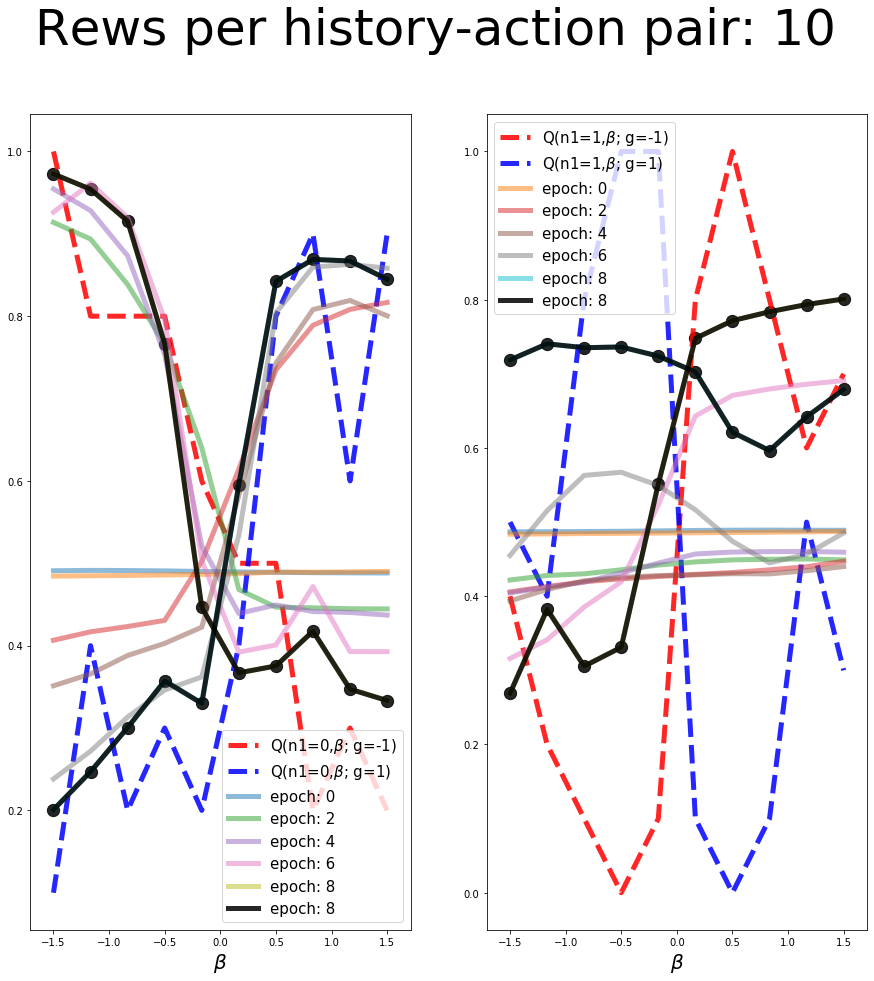

In [97]:
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")